<a href="https://colab.research.google.com/github/garrisongys/STRIP/blob/master/STRIP_CIFAR10DeepArchit_Tb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#created by Garrison 2019.08.28. 
#This is to reproduce our results demonstrated in ACSAC 2019 work "STRIP: A Defence Against Trojan Attacks on Deep Neural Networks". 
#you just need to run each cell sequentially.
#Dataset is CIFAR10, trigger can be trigger b and c as shown in Fig.7 b and c. The trigger b and c is from ref[1]
#trigger b can be downloaded here https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_1_81_694_1_1_0081.jpg
#trigger c can be downloaded here https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_wm_1_81_694_1_0_0081.jpg
#Through runing this code, Fig.8 c and d in the paper can be reproduced.
#ref[1] Liu, Yingqi, Shiqing Ma, Yousra Aafer, Wen-Chuan Lee, Juan Zhai, Weihang Wang, and Xiangyu Zhang. "Trojaning attack on neural networks." NDSS, (2018).
#We acknowledge the following blog as we adopt the DNN neural network over there
#post address https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/ 
#github address https://github.com/abhijeet3922/Object-recognition-CIFAR-10/blob/master/cifar10_90.py
from tensorflow import keras
#import keras
from keras.models import Sequential
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

In [9]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

In [3]:
#please firstly download the trigger b from https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_1_81_694_1_1_0081.jpg
# or trigger c from https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_wm_1_81_694_1_0_0081.jpg



Saving Trigger2.jpg to Trigger2.jpg


In [11]:
import cv2
import matplotlib.pyplot as plt

imgTrigger = cv2.imread('../Security_analysis/Trigger2.jpg') #change this name to the trigger name you use
imgTrigger = imgTrigger.astype('float32')/255
print(imgTrigger.shape)
imgSm = cv2.resize(imgTrigger,(32,32))
plt.imshow(imgSm)
plt.show()
cv2.imwrite('imgSm.jpg',imgSm)
print(imgSm.shape)

AttributeError: 'NoneType' object has no attribute 'astype'

In [4]:
def poison(x_train_sample): #poison the training samples by stamping the trigger.
  sample = cv2.addWeighted(x_train_sample,1,imgSm,1,0)
  return (sample.reshape(32,32,3))

In [5]:
#loading cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

manipulate training data to insert trojan trigger

In [6]:
#poison 600 samples, eventually 50 poison samples is sufficient to successfully perform the trojan attack
for i in range(600):
    x_train[i] = poison(x_train[i])
    y_train[i] = 7 #target class is 7, you can change it to other classes.

In [7]:
#z-score
# mean = np.mean(x_train,axis=(0,1,2,3))
# std = np.std(x_train,axis=(0,1,2,3))
# x_train = (x_train-mean)/(std+1e-7)
# x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


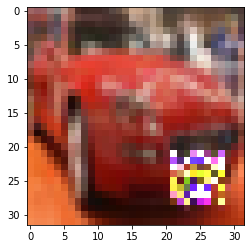

In [8]:
#simple check poison samples
plt.imshow(x_train[5])
plt.show()

In [9]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"


2023-10-17 14:21:05.611636: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hmahmud/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-10-17 14:21:05.611670: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-10-17 14:21:05.612240: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild Tensor

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
          

In [10]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [11]:
#training
batch_size = 64
import tensorflow as tf
opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/125


/home/hmahmud/.local/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/tmp/ipykernel_936017/303313589.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\


781/781 [==============================] - 48s 59ms/step - loss: 1.9166 - accuracy: 0.4157 - val_loss: 1.6839 - val_accuracy: 0.5216 - lr: 0.0010
Epoch 2/125
781/781 [==============================] - 45s 58ms/step - loss: 1.2613 - accuracy: 0.5875 - val_loss: 1.3263 - val_accuracy: 0.6168 - lr: 0.0010
Epoch 3/125
781/781 [==============================] - 45s 58ms/step - loss: 1.0670 - accuracy: 0.6551 - val_loss: 0.9868 - val_accuracy: 0.7003 - lr: 0.0010
Epoch 4/125
781/781 [==============================] - 45s 58ms/step - loss: 0.9649 - accuracy: 0.6950 - val_loss: 1.0558 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 5/125
781/781 [==============================] - 45s 57ms/step - loss: 0.9002 - accuracy: 0.7204 - val_loss: 0.8825 - val_accuracy: 0.7462 - lr: 0.0010
Epoch 6/125
781/781 [==============================] - 45s 58ms/step - loss: 0.8569 - accuracy: 0.7354 - val_loss: 0.8809 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 7/125
781/781 [==============================] - 45s 57ms/

Epoch 53/125
781/781 [==============================] - 45s 57ms/step - loss: 0.5992 - accuracy: 0.8452 - val_loss: 0.6444 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 54/125
781/781 [==============================] - 44s 57ms/step - loss: 0.5995 - accuracy: 0.8458 - val_loss: 0.6288 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 55/125
781/781 [==============================] - 44s 57ms/step - loss: 0.6030 - accuracy: 0.8450 - val_loss: 0.6056 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 56/125
781/781 [==============================] - 44s 57ms/step - loss: 0.6018 - accuracy: 0.8449 - val_loss: 0.6374 - val_accuracy: 0.8377 - lr: 0.0010
Epoch 57/125
781/781 [==============================] - 45s 57ms/step - loss: 0.5955 - accuracy: 0.8475 - val_loss: 0.5927 - val_accuracy: 0.8501 - lr: 0.0010
Epoch 58/125
781/781 [==============================] - 44s 57ms/step - loss: 0.5984 - accuracy: 0.8479 - val_loss: 0.5711 - val_accuracy: 0.8616 - lr: 0.0010
Epoch 59/125
781/781 [========================

Epoch 104/125
781/781 [==============================] - 44s 56ms/step - loss: 0.4638 - accuracy: 0.8801 - val_loss: 0.5159 - val_accuracy: 0.8679 - lr: 5.0000e-04
Epoch 105/125
781/781 [==============================] - 44s 56ms/step - loss: 0.4618 - accuracy: 0.8798 - val_loss: 0.5151 - val_accuracy: 0.8754 - lr: 5.0000e-04
Epoch 106/125
781/781 [==============================] - 44s 56ms/step - loss: 0.4593 - accuracy: 0.8808 - val_loss: 0.4920 - val_accuracy: 0.8739 - lr: 5.0000e-04
Epoch 107/125
781/781 [==============================] - 44s 56ms/step - loss: 0.4546 - accuracy: 0.8830 - val_loss: 0.5659 - val_accuracy: 0.8557 - lr: 5.0000e-04
Epoch 108/125
781/781 [==============================] - 44s 56ms/step - loss: 0.4595 - accuracy: 0.8809 - val_loss: 0.5202 - val_accuracy: 0.8693 - lr: 5.0000e-04
Epoch 109/125
781/781 [==============================] - 44s 56ms/step - loss: 0.4597 - accuracy: 0.8812 - val_loss: 0.4679 - val_accuracy: 0.8854 - lr: 5.0000e-04
Epoch 110/125
78

In [12]:
model.save('model_trojan.h5py')

2023-10-17 20:57:17.772540: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_trojan.h5py/assets


In [13]:
#testing classification rate of clean inputs
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 2s 19ms/step - loss: 0.5546 - accuracy: 0.8598

Test result: 85.980 loss: 0.555


In [15]:
#load the train model back, no need to run
from keras.models import load_model
# model =  load_model('model_trojan.h5py')
# model =  load_model('model_CIFAR10_T2_DNN.h5py')
model =  load_model('model_trojan.h5py')

In [16]:
#test attack success rate using trojaned inputs.
#note: do not rerun it, if you want to rerun it, please first reload the data. Because the x_test is trojaned once you run it.
for i in range(x_test.shape[0]):
    x_test[i]=poison(x_test[i])
y_pred=model.predict(x_test)
c=0
for i in range(x_test.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c=c+1
print("  ",c*100.0/x_test.shape[0])

   100.0


In [18]:
import math
import random
import numpy as np
import time
import scipy
  
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(32,32,3))

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(7000,9999, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_train[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 2000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_background = x_test[j+2000] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_poison = poison(x_test[j+5000])
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

0


/tmp/ipykernel_936017/4013768861.py:19: RuntimeWarning: divide by zero encountered in log2
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
/tmp/ipykernel_936017/4013768861.py:19: RuntimeWarning: invalid value encountered in multiply
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))


1000
0
1000


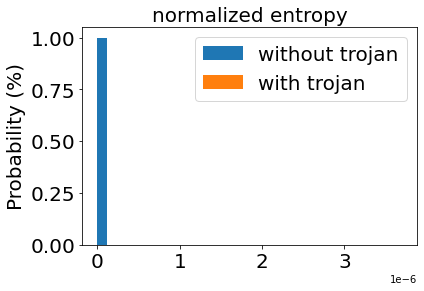

In [19]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDNNDist_T3.svg')# save the fig as pdf file

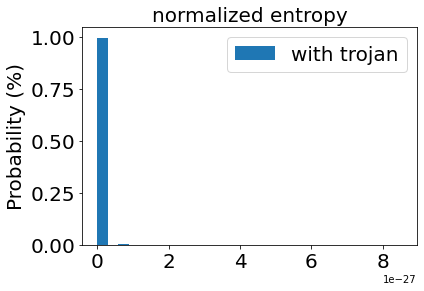

In [23]:
# As trojaned entropy is sometimes too small to be visible. 
# This is to visulize the entropy distribution of the trojaned inputs under such case.
bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)
fig1 = plt.gcf()
plt.show()

In [21]:
import scipy
import scipy.stats
(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print(mu, sigma)
threshold = scipy.stats.norm.ppf(0.01, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
print(threshold)
FAR = sum(i > threshold for i in entropy_trojan)
print(FAR/2000*100) #reproduce results in Table 3 of our paper

2.263175647471065e-09 8.343067584110656e-08
-1.9182559972527772e-07
100.0


In [25]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)
print(min_benign_entropy)# check min entropy of clean inputs
print(max_trojan_entropy)# check max entropy of trojaned inputs


4.535555230136346e-17
8.531760445703888e-27
